<a href="https://colab.research.google.com/github/mahdi943/logistic-regression/blob/master/ML_Bigger_fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing pyspark


In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version
!pip install pyspark

#Importing required libs 

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoder,PCA
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

#Reading csv file 

In [ ]:
from pyspark.sql import SparkSession 

spark = SparkSession.builder.getOrCreate()
mpgDF= spark.read.option("header","true").csv("/content/drive/MyDrive/Colab Notebooks/dataset/dataset-1.csv")
# mpgDF.show(10)


# Convert string to float

In [ ]:
from pyspark.sql.functions import col

#Drop null values(row)
df = mpgDF.na.drop()
df = df.select(*(col(c).cast("float").alias(c) for c in df.columns))
# df.show(10)


# Transform to VectorAssembler as features

In [ ]:
dfVEC =  VectorAssembler(inputCols=df.columns[1:621], outputCol='features')
df = dfVEC.transform(df)

df = df.select('features','label')
df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[23867.0,18724.0,...|  0.0|
|[24435.0,24182.0,...|  0.0|
|[19578.0,18170.0,...|  0.0|
|[26331.0,14766.0,...|  0.0|
|[20955.0,25040.0,...|  0.0|
+--------------------+-----+
only showing top 5 rows



# Random splitting data to 70% train and 30% test 

In [ ]:

from pyspark.ml.classification import LogisticRegression

train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

Training Dataset Count: 136
Test Dataset Count: 64


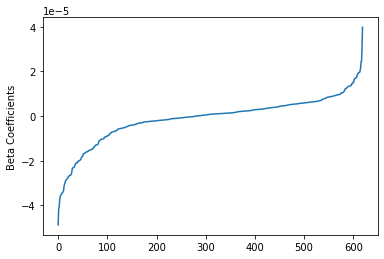

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

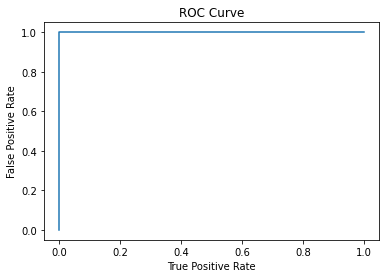

Training set areaUnderROC: 1.0


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

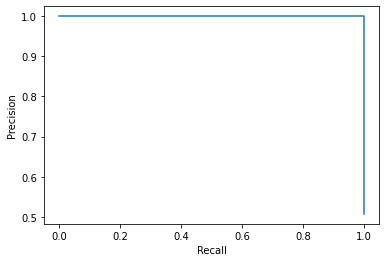

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
predictions = lrModel.transform(test)
predictions.select('label',  'features').show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[11882.0,20515.0,...|
|  1.0|[13215.0,17000.0,...|
|  0.0|[13867.0,21802.0,...|
|  0.0|[14022.0,18582.0,...|
|  1.0|[14345.0,16309.0,...|
|  1.0|[14726.0,21924.0,...|
|  1.0|[15297.0,18250.0,...|
|  0.0|[16145.0,21869.0,...|
|  0.0|[16358.0,14782.0,...|
|  1.0|[16367.0,15594.0,...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9765395894428153
